In [1]:
from torch_geometric.data import DataLoader
from torch.utils.data import DataLoader as TorchDataLoader
import numpy as np
import torch
from torch import nn
from torch import optim
import time
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel
import torch.nn.functional as F
import math
from torch_geometric.nn import GATConv, global_mean_pool, GATv2Conv, GINConv, global_add_pool, BatchNorm
import os
import os.path as osp
from torch_geometric.data import Dataset 
from torch_geometric.data import Data
from torch.utils.data import Dataset as TorchDataset
import pandas as pd

/home/axeldum/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class GraphTextDataset(Dataset):
    def __init__(self, root, gt, split, tokenizer=None, transform=None, pre_transform=None):
        self.root = root
        self.gt = gt
        self.split = split
        self.tokenizer = tokenizer
        self.description = pd.read_csv(os.path.join(self.root, split+'.tsv'), sep='\t', header=None)   
        self.description = self.description.set_index(0).to_dict()
        self.cids = list(self.description[1].keys())
        self.data_cache = {}  # Dictionary to store loaded data
        self.idx_to_cid = {}

        i = 0
        for cid in self.cids:
            self.idx_to_cid[i] = cid
            i += 1
        super(GraphTextDataset, self).__init__(root, transform, pre_transform)

    @property
    def raw_file_names(self):
        return [str(cid) + ".graph" for cid in self.cids]

    @property
    def processed_file_names(self):
        return ['data_{}.pt'.format(cid) for cid in self.cids]
    
    @property
    def raw_dir(self) -> str:
        return osp.join(self.root, 'raw')

    @property
    def processed_dir(self) -> str:
        return osp.join(self.root, 'processed/', self.split)

    def download(self):
        pass
        
    def process_graph(self, raw_path):
      edge_index  = []
      x = []
      with open(raw_path, 'r') as f:
        next(f)
        for line in f: 
          if line != "\n":
            edge = *map(int, line.split()), 
            edge_index.append(edge)
          else:
            break
        next(f)
        for line in f: #get mol2vec features:
          substruct_id = line.strip().split()[-1]
          if substruct_id in self.gt.keys():
            x.append(self.gt[substruct_id])
          else:
            x.append(self.gt['UNK'])
        return torch.LongTensor(edge_index).T, torch.FloatTensor(x)

    
    def process(self):
        i = 0        
        for raw_path in self.raw_paths:
            cid = int(raw_path.split('/')[-1][:-6])

            description = self.description[1][cid]

            text_input = self.tokenizer([description],
                                   return_tensors="pt", 
                                   truncation=True, 
                                   max_length=256,
                                   padding="max_length",
                                   add_special_tokens=True,)
            edge_index, x = self.process_graph(raw_path)
            data = Data(x=x, edge_index=edge_index, input_ids=text_input['input_ids'], attention_mask=text_input['attention_mask'])
            torch.save(data, osp.join(self.processed_dir, 'data_{}.pt'.format(cid)))
            i += 1
 
    def len(self):
        return len(self.cids)

    def get(self, idx):
        if idx in self.data_cache:
            # Return cached data if it's already loaded
            return self.data_cache[idx]

        # Load the data from the disk
        data = torch.load(osp.join(self.processed_dir, 'data_{}.pt'.format(self.idx_to_cid[idx])))

        # Cache the loaded data
        self.data_cache[idx] = data
        
        return data


    def get_cid(self, cid):
        data = torch.load(osp.join(self.processed_dir, 'data_{}.pt'.format(cid)))
        return data
    
    
class GraphDataset(Dataset):
    def __init__(self, root, gt, split, transform=None, pre_transform=None):
        self.root = root
        self.gt = gt
        self.split = split
        self.description = pd.read_csv(os.path.join(self.root, split+'.txt'), sep='\t', header=None)
        self.cids = self.description[0].tolist()
        
        self.idx_to_cid = {}
        i = 0
        for cid in self.cids:
            self.idx_to_cid[i] = cid
            i += 1
        super(GraphDataset, self).__init__(root, transform, pre_transform)

    @property
    def raw_file_names(self):
        return [str(cid) + ".graph" for cid in self.cids]

    @property
    def processed_file_names(self):
        return ['data_{}.pt'.format(cid) for cid in self.cids]
    
    @property
    def raw_dir(self) -> str:
        return osp.join(self.root, 'raw')

    @property
    def processed_dir(self) -> str:
        return osp.join(self.root, 'processed/', self.split)

    def download(self):
        pass
        
    def process_graph(self, raw_path):
      edge_index  = []
      x = []
      with open(raw_path, 'r') as f:
        next(f)
        for line in f: 
          if line != "\n":
            edge = *map(int, line.split()), 
            edge_index.append(edge)
          else:
            break
        next(f)
        for line in f:
          substruct_id = line.strip().split()[-1]
          if substruct_id in self.gt.keys():
            x.append(self.gt[substruct_id])
          else:
            x.append(self.gt['UNK'])
        return torch.LongTensor(edge_index).T, torch.FloatTensor(x)

    def process(self):
        i = 0        
        for raw_path in self.raw_paths:
            cid = int(raw_path.split('/')[-1][:-6])
            edge_index, x = self.process_graph(raw_path)
            data = Data(x=x, edge_index=edge_index)
            torch.save(data, osp.join(self.processed_dir, 'data_{}.pt'.format(cid)))
            i += 1

    def len(self):
        return len(self.processed_file_names)

    def get(self, idx):
        data = torch.load(osp.join(self.processed_dir, 'data_{}.pt'.format(self.idx_to_cid[idx])))
        return data

    def get_cid(self, cid):
        data = torch.load(osp.join(self.processed_dir, 'data_{}.pt'.format(cid)))
        return data
    
    def get_idx_to_cid(self):
        return self.idx_to_cid
    
class TextDataset(TorchDataset):
    def __init__(self, file_path, tokenizer, max_length=256):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.sentences = self.load_sentences(file_path)

    def load_sentences(self, file_path):
        with open(file_path, 'r', encoding='utf-8') as file:
            lines = file.readlines()
        return [line.strip() for line in lines]

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]

        encoding = self.tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze()
        }

In [3]:
class GraphEncoder(nn.Module):
    def __init__(self, num_node_features, nout, nhid, heads=1):
        super(GraphEncoder, self).__init__()
        self.nhid = nhid
        self.nout = nout
        self.heads = heads
        self.relu = nn.LeakyReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.ln = nn.LayerNorm(nout)
        self.bn = BatchNorm(nhid * self.heads)

        # Define the GAT layers
        self.conv1 = GATv2Conv(num_node_features, nhid, heads=self.heads)
        self.conv2 = GATv2Conv(nhid * self.heads, nhid, heads=self.heads)
        self.conv3 = GATv2Conv(nhid * self.heads, nhid, heads=self.heads)
        self.mol_hidden1 = nn.Linear(nhid * self.heads, nhid)
        self.mol_hidden2 = nn.Linear(nhid, nout)
        
    def forward(self, graph_batch):
        x = graph_batch.x
        edge_index = graph_batch.edge_index
        batch = graph_batch.batch

        # Apply the GAT layers
        x = self.conv1(x, edge_index)
        #x = self.bn(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        #x = self.bn(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.conv3(x, edge_index)
        #x = self.bn(x)
        x = self.relu(x)
        x = self.dropout(x)       

        x = global_mean_pool(x, batch)
        x = self.mol_hidden1(x).relu()
        x = self.mol_hidden2(x)
        x = self.ln(x)


        
        return x

class GIN(torch.nn.Module):
    """GIN"""
    def __init__(self, num_node_features, nout, nhid):
        super(GIN, self).__init__()
        self.conv1 = GINConv(
            nn.Sequential(nn.Linear(num_node_features, nhid),
                       nn.BatchNorm1d(nhid), nn.ReLU(),
                       nn.Linear(nhid, nhid), nn.ReLU()))
        self.conv2 = GINConv(
           nn.Sequential(nn.Linear(nhid, nhid), nn.BatchNorm1d(nhid), nn.ReLU(),
                       nn.Linear(nhid, nhid), nn.ReLU()))
        self.conv3 = GINConv(
            nn.Sequential(nn.Linear(nhid, nhid), nn.BatchNorm1d(nhid), nn.ReLU(),
                       nn.Linear(nhid, nhid), nn.ReLU()))
        self.lin1 = nn.Linear(nhid*3, nhid*3)
        self.lin2 = nn.Linear(nhid*3, nout)

    def forward(self, graph_batch):
        x, edge_index, batch = graph_batch.x, graph_batch.edge_index, graph_batch.batch

        # Node embeddings 
        h1 = self.conv1(x, edge_index)
        h2 = self.conv2(h1, edge_index)
        h3 = self.conv3(h2, edge_index)

        # Graph-level readout
        h1 = global_add_pool(h1, batch)
        h2 = global_add_pool(h2, batch)
        h3 = global_add_pool(h3, batch)

        # Concatenate graph embeddings
        h = torch.cat((h1, h2, h3), dim=1)

        # Classifier
        h = self.lin1(h)
        h = h.relu()
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.lin2(h)

        return h

class TextEncoder(nn.Module):
    def __init__(self, model_name):
        super(TextEncoder, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        
    def forward(self, input_ids, attention_mask):
        encoded_text = self.bert(input_ids, attention_mask=attention_mask)
        return encoded_text.last_hidden_state[:, 0, :]

        
        
    

class Model(nn.Module):
    
    def __init__(self, model_name, num_node_features, nhid_gat):
        super(Model, self).__init__()
        self.text_encoder = TextEncoder(model_name)
        self.graph_encoder = GIN(num_node_features, self.text_encoder.nhid, nhid_gat)
        
    def forward(self, graph_batch, input_ids, attention_mask):
        graph_encoded = self.graph_encoder(graph_batch)
        text_encoded = self.text_encoder(input_ids, attention_mask)
        return graph_encoded, text_encoded

    def get_text_encoder(self):
        return self.text_encoder

    def get_graph_encoder(self):
        return self.graph_encoder

In [4]:
CE = torch.nn.CrossEntropyLoss()
def contrastive_loss(v1, v2):
  logits = torch.matmul(v1,torch.transpose(v2, 0, 1))
  labels = torch.arange(logits.shape[0], device=v1.device)
  return CE(logits, labels) + CE(torch.transpose(logits, 0, 1), labels)

tokenizer_name = "emilyalsentzer/Bio_ClinicalBERT"
# tokenizer_name = "allenai/scibert_scivocab_uncased"
# tokenizer_name = "WhereIsAI/UAE-Large-V1"
# tokenizer_name = "FacebookAI/roberta-base"
# tokenizer_name = "mrm8488/chEMBL_smiles_v1"

tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
gt = np.load("/mnt/c/Users/axeld/Documents/altegrad/data/token_embedding_dict.npy", allow_pickle=True)[()]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
val_dataset = GraphTextDataset(root='/mnt/c/Users/axeld/Documents/altegrad/data/', gt=gt, split='val', tokenizer=tokenizer)
train_dataset = GraphTextDataset(root='/mnt/c/Users/axeld/Documents/altegrad/data/', gt=gt, split='train', tokenizer=tokenizer)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

nb_epochs = 40
batch_size = 32
learning_rate = 1e-4
bert_lr = 3e-5

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

model = Model(tokenizer_name, num_node_features=300, nhid_gat=300)
model.to(device)

"""optimizer = optim.AdamW(model.parameters(), lr=learning_rate,
                                betas=(0.9, 0.999),
                                weight_decay=0.05)"""

optimizer = optim.AdamW([
                {'params': model.graph_encoder.parameters()},
                {'params': model.text_encoder.parameters(), 'lr': bert_lr}
            ], lr=learning_rate, betas=(0.9, 0.999), weight_decay=0.05)

epoch = 0
loss = 0
losses = []
count_iter = 0
time1 = time.time()
printEvery = 50
best_validation_loss = 1000000

epoch = 0
loss = 0
losses = []
count_iter = 0
time1 = time.time()
printEvery = 50
best_validation_loss = 1000000

/home/axeldum/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/axeldum/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [5]:
train_loss = []
valid_loss = []

for i in range(nb_epochs):
    print('-----EPOCH{}-----'.format(i+1))
    model.train()
    for batch in train_loader:
        input_ids = batch.input_ids
        batch.pop('input_ids')
        attention_mask = batch.attention_mask
        batch.pop('attention_mask')
        graph_batch = batch

        x_graph, x_text = model(graph_batch.to(device),
                                input_ids.to(device),
                               attention_mask.to(device))
        current_loss = contrastive_loss(x_graph, x_text)
        optimizer.zero_grad()
        current_loss.backward()
        optimizer.step()
        loss += current_loss.item()

        count_iter += 1
        if count_iter % printEvery == 0:
            time2 = time.time()
            print("Iteration: {0}, Time: {1:.4f} s, training loss: {2:.4f}".format(count_iter,
                                                                        time2 - time1, loss/printEvery))
            train_loss.append(loss/printEvery)
            losses.append(loss)
            loss = 0 
    model.eval()       
    val_loss = 0        
    for batch in val_loader:
        input_ids = batch.input_ids
        batch.pop('input_ids')
        attention_mask = batch.attention_mask
        batch.pop('attention_mask')
        graph_batch = batch
        x_graph, x_text = model(graph_batch.to(device),
                                input_ids.to(device),
                               attention_mask.to(device))
        current_loss = contrastive_loss(x_graph, x_text)   
        val_loss += current_loss.item()
    best_validation_loss = min(best_validation_loss, val_loss)
    print('-----EPOCH'+str(i+1)+'----- done.  Validation loss: ', str(val_loss/len(val_loader)) )
    valid_loss.append(val_loss/len(val_loader))
    if best_validation_loss==val_loss:
        print('validation loss improved saving checkpoint...')
        save_path = os.path.join('./', 'model.pt')
        torch.save({
        'epoch': i,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'validation_accuracy': val_loss,
        'loss': loss,
        }, save_path)
        print('checkpoint saved to: {}'.format(save_path))

-----EPOCH1-----


../aten/src/ATen/native/cuda/Indexing.cu:1292: indexSelectLargeIndex: block: [249,0,0], thread: [96,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1292: indexSelectLargeIndex: block: [249,0,0], thread: [97,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1292: indexSelectLargeIndex: block: [249,0,0], thread: [98,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1292: indexSelectLargeIndex: block: [249,0,0], thread: [99,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1292: indexSelectLargeIndex: block: [249,0,0], thread: [100,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1292: indexSelectLargeIndex: block: [249,0,0], thread: [101,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1292: indexSelectLargeIndex: block: [24

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


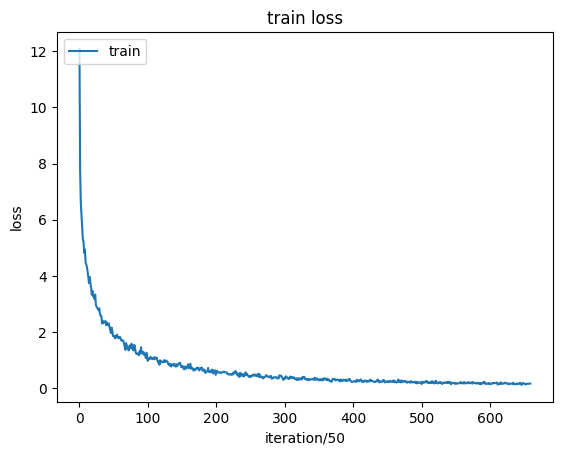

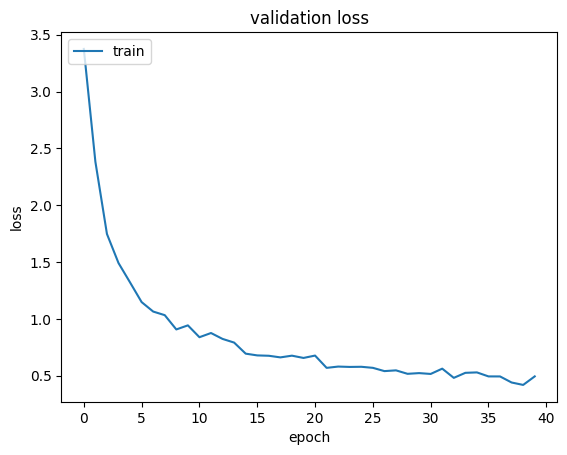

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_loss)
plt.title('train loss')
plt.ylabel('loss')
plt.xlabel('iteration/50')
plt.legend(['train'], loc='upper left')
plt.show()
plt.plot(valid_loss)
plt.title('validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
print('loading best model...')
checkpoint = torch.load(save_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

graph_model = model.get_graph_encoder()
text_model = model.get_text_encoder()

test_cids_dataset = GraphDataset(root='/mnt/c/Users/axeld/Documents/altegrad/data/', gt=gt, split='test_cids')
test_text_dataset = TextDataset(file_path='/mnt/c/Users/axeld/Documents/altegrad/data/test_text.txt', tokenizer=tokenizer)

idx_to_cid = test_cids_dataset.get_idx_to_cid()

test_loader = DataLoader(test_cids_dataset, batch_size=batch_size, shuffle=False)

graph_embeddings = []
for batch in test_loader:
    for output in graph_model(batch.to(device)):
        graph_embeddings.append(output.tolist())

test_text_loader = TorchDataLoader(test_text_dataset, batch_size=batch_size, shuffle=False)
text_embeddings = []
for batch in test_text_loader:
    input_ids = batch['input_ids']
    attn_mask = batch['attention_mask']
    for output in text_model(input_ids.to(device), 
                             attn_mask.to(device)):
        text_embeddings.append(output.tolist())


from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import label_ranking_average_precision_score

similarity = cosine_similarity(text_embeddings, graph_embeddings)
labels = np.eye(len(similarity))

print(label_ranking_average_precision_score(labels, similarity))

solution = pd.DataFrame(similarity)
solution['ID'] = solution.index
solution = solution[['ID'] + [col for col in solution.columns if col!='ID']]
solution.to_csv('submission.csv', index=False)

loading best model...


/home/axeldum/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


0.003050884032535842
